In [1]:
import sys

sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.stimulus import RegularStimulus
from spikeometric.datasets import NormalGenerator, UniformGenerator
from torch_geometric.utils import to_networkx, from_networkx, to_dense_adj

from CD_methods import observational_learner_Poisson, interventional_learner_Poisson
from functions import *

In [2]:
seed=78

In [19]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

G = nx.DiGraph()
# confounding and causal interaction
direct = [(1,2)]
bidirect = [(1,2),(2,1)]
independent = [(0,1)]

fork = [(0,1),(0,2)]
collider = [(1,0),(2,0)]
chain = [(1,0),(0,2)]

G.add_nodes_from([0,1,2])
G.add_edges_from(fork)
network = from_networkx(G)
network.W0 = torch.tensor([2, 2])
spikes = neuron_model.simulate(network,n_steps=10**4)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 18086.75it/s]


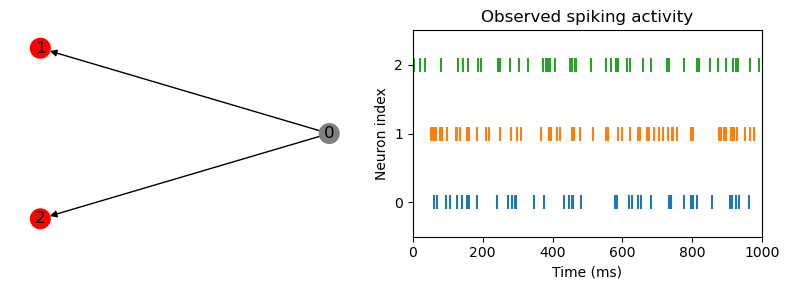

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
nx.draw_circular(G, node_color=['grey','red','red'], with_labels=True,node_size=200,ax=ax[0])
make_rasterplot(spikes)
plt.show()

In [21]:
G_learned_null = observational_learner_Poisson(
        {'null': spikes[[1,2]]}, 
        node_list=[1,2], 
        alpha = 5*1e-1,)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.09it/s]


In [22]:
print(G_learned_null.edges())

[(1, 2), (2, 1)]


In [29]:
spike_data_dict={}
stimulus_mask = torch.zeros(3, dtype=torch.bool)
stimulus_mask[1]=True
print(stimulus_mask)
neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
spikes_intervention = neuron_model.simulate(network, n_steps=10**4)
spike_data_dict['1'] = spikes_intervention[[1,2]]

stimulus_mask = torch.zeros(3, dtype=torch.bool)
stimulus_mask[2]=True
print(stimulus_mask)
neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
spikes_intervention = neuron_model.simulate(network, n_steps=10**4)
spike_data_dict['2'] = spikes_intervention[[1,2]]

tensor([False,  True, False])


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 17889.44it/s]


tensor([False, False,  True])


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 18152.90it/s]


In [33]:
G_learned = interventional_learner_Poisson(
        spike_data_dict, 
        stimulation_protocol=[[1], [2]],
        SCM_learned=G_learned_null,
        node_list=[1,2], 
        alpha = 1e-1,)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.68it/s]


In [34]:
print(G_learned.edges())

[]


In [116]:
def generate_W0(graph, p, w_exc=1.5, w_inh=-3.0):
    W0 = torch.from_numpy(nx.to_numpy_array(graph))
    n_neurons = graph.number_of_nodes()
    are_excitatory = np.random.choice(n_neurons, size=n_neurons//2, replace=False)
    are_inhibitory = [neuron for neuron in range(n_neurons) if neuron not in are_excitatory]

    for i in are_excitatory:
        for j in range(n_neurons):
            if W0[i, j] == 1:
                W0[i, j] = np.random.beta(a=2,b=2)*3
    
    for i in are_inhibitory:
        for j in range(n_neurons):
            if W0[i, j] == 1:
                W0[i, j] = -np.random.beta(a=2,b=2)*6
                
    edge_index = W0.nonzero().t()
    W0_ = W0[edge_index[0], edge_index[1]]
    
    return W0_.to(dtype=torch.float32)

In [117]:
def generate_networks(n_networks, p, n_neurons, seed):
    network_data = []
    
    for _ in range(n_networks):
        graph = nx.erdos_renyi_graph(n=n_neurons, p=p, directed=True, seed=seed)
        network = from_networkx(graph)
        network.W0 = generate_W0(graph, p)
        network_data.append(network)
        
    return network_data

In [118]:
n_neurons = 10
p = 0.3
graph = nx.erdos_renyi_graph(n=n_neurons, p=p, directed=True, seed=seed)
network = from_networkx(graph)

In [385]:
n_obs = 10
n_hidden = 10
n_networks = 10
n_timesteps = 10**4

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=0.1, seed=seed)

res={'TP': [], 'FP': [], 'TN':[], 'FN':[], 'SHD': [], 'sensitivity': [], 'specificity': []}
plot = True

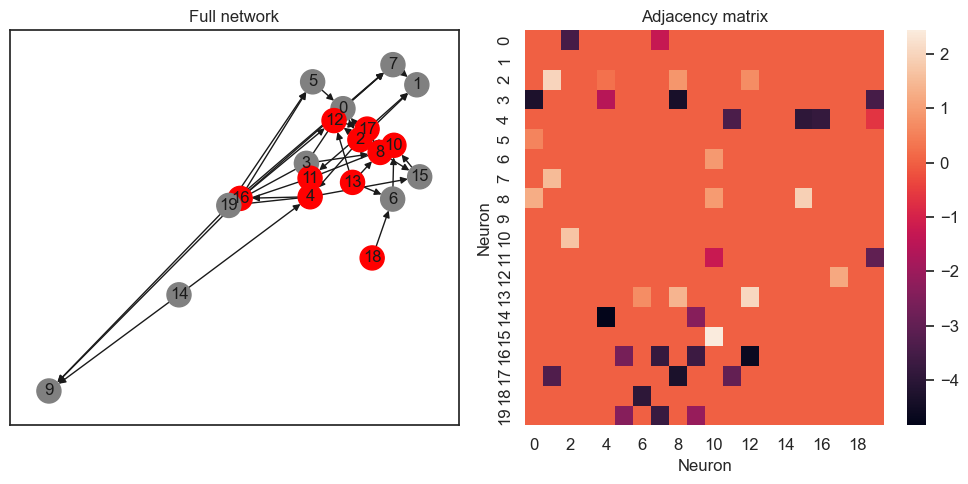

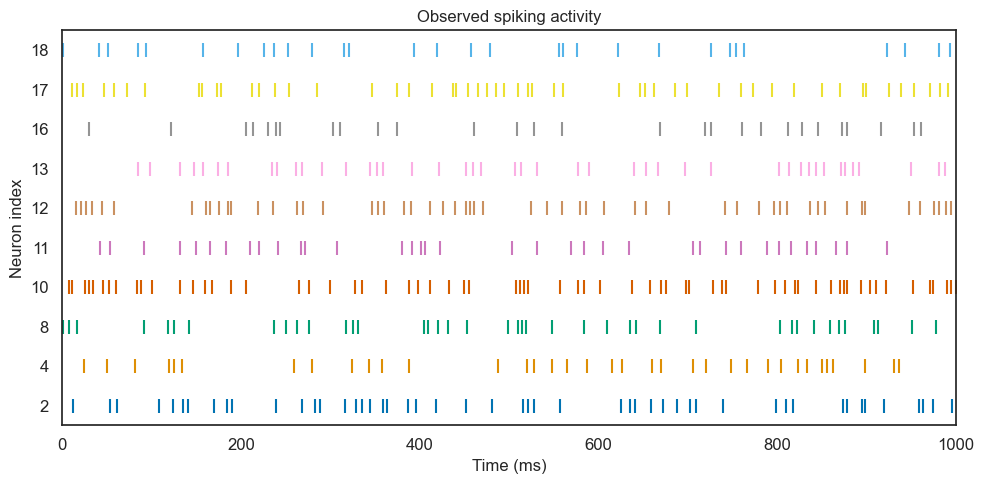

 10%|████▍                                       | 1/10 [00:03<00:35,  3.91s/it]


KeyboardInterrupt: 

In [386]:
for i in range(n_networks):
    network = network_data[i]
    index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

    spike_data = dict()
    spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)
    spike_data['null'] = spikes[index_obs]
    
    G = to_networkx(network)   
    node_color = ['red' if node in index_obs else 'grey' for node in G.nodes()]
    
    if plot:
        # visualisation of one of the networks generated
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=node_color)
        ax[0].set_title("Full network")
        W0 = to_dense_adj(network.edge_index, edge_attr=network.W0, max_num_nodes=network.num_nodes)[0]
        sns.heatmap(W0, ax=ax[1], annot=False)
        ax[1].set_title("Adjacency matrix")
        ax[1].set_xlabel("Neuron")
        ax[1].set_ylabel("Neuron")
        plt.tight_layout()
        plt.show()
    
        spikes = spike_data['null']
        plt.figure(figsize=(10,5))
        for i in range(len(index_obs)):
            plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)
        plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
        plt.xlabel("Time (ms)")
        plt.ylabel("Neuron index")
        plt.xlim([0, 1000])
        plt.ylim([-0.5, n_obs - 0.5])
        plt.title("Observed spiking activity")
        plt.tight_layout()
        plt.show()

    
    
    G_true = nx.subgraph(G, index_obs)

    G_learned_null = observational_learner_Poisson(
        spike_data, 
        node_list=index_obs, 
        alpha = 1e-2)
    
    res['SHD'].append(compute_SHD(G_true, G_learned_null))
    res['TP'].append(count_true_positive(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['TN'].append(count_true_negative(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['FP'].append(count_false_positive(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['FN'].append(count_false_negative(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['sensitivity'].append(compute_sensitivity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['specificity'].append(compute_specificity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    #print(res)

In [130]:
import pandas as pd

In [244]:
df3 = pd.DataFrame(res)
df3['F1'] = 2*df3['TP'] / (2*df3['TP'] + df3['FP'] + df3['FN'])

In [245]:
df3

,TP,FP,TN,FN,SHD,sensitivity,specificity,F1
0,20,3,75,2,5,0.869565,0.974026,0.888889
1,17,6,74,3,9,0.739130,0.961039,0.790698
2,21,1,74,4,5,0.954545,0.948718,0.893617
3,12,9,79,0,9,0.571429,1.000000,0.727273
4,18,0,80,2,2,1.000000,0.975610,0.947368
5,15,1,80,4,5,0.937500,0.952381,0.857143
6,21,1,77,1,2,0.954545,0.987179,0.954545
7,18,5,75,2,7,0.782609,0.974026,0.837209
8,22,1,77,0,1,0.956522,1.000000,0.977778
9,10,3,86,1,4,0.769231,0.988506,0.833333


In [246]:
df3.mean().round(3)

TP             17.400
FP              3.000
TN             77.700
FN              1.900
SHD             4.900
sensitivity     0.854
specificity     0.976
F1              0.871
dtype: float64

In [187]:
df2.std().round(3)

TP             3.864
FP             1.969
TN             3.773
FN             2.667
SHD            3.213
sensitivity    0.041
specificity    0.051
F1             0.035
dtype: float64

In [182]:
df2.std().round(3)

TP             3.864
FP             1.969
TN             3.773
FN             2.667
SHD            3.213
sensitivity    0.041
specificity    0.051
F1             0.041
dtype: float64

In [168]:
df.mean().round(3)

TP             18.100
FP              2.600
TN             77.500
FN              1.800
SHD             4.400
sensitivity     0.874
specificity     0.977
F1              0.889
dtype: float64

In [148]:
np.mean(df['SHD']/(10*9/2))

0.09777777777777777

In [149]:
np.std(df['SHD']/(10*9/2))

0.04121608220220313

In [153]:
df['F1'] = 2*df['TP'] / (2*df['TP'] + df['FP'] + df['FN'])

TP             18.100
FP              2.600
TN             77.500
FN              1.800
SHD             4.400
sensitivity     0.874
specificity     0.977
F1              0.889
dtype: float64

In [160]:
df.std().round(3)

TP             2.923
FP             1.578
TN             2.550
FN             1.135
SHD            1.955
sensitivity    0.076
specificity    0.014
F1             0.051
dtype: float64

In [388]:
sns.set_theme(palette="colorblind",style="ticks",context='notebook')

cm=1/2.54
params = {
    'legend.fontsize': 12,
    'font.size': 12,
    'figure.figsize': (18*cm,9.0*cm), # figsize for two-column latex doc
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.markersize': 3.0,
    'lines.linewidth': 1.5,
    }

plt.rcParams.update(params)

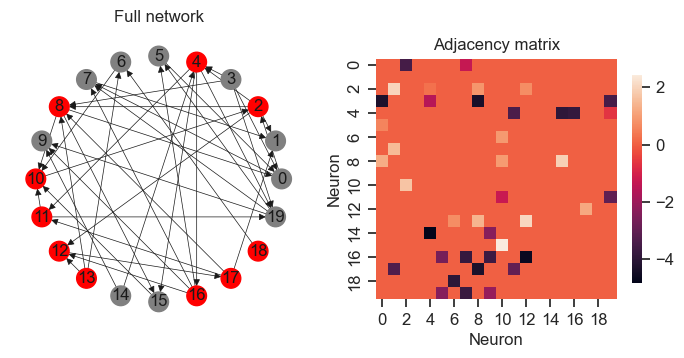

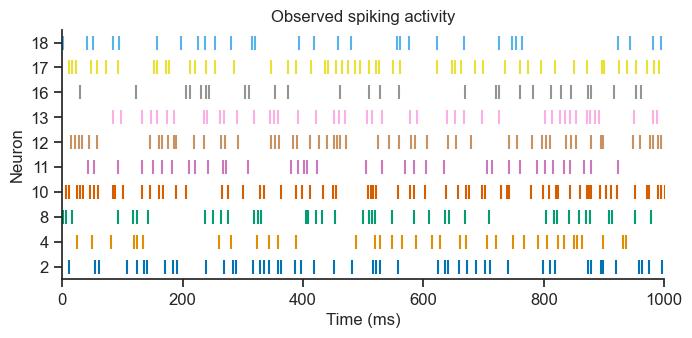

In [391]:
fig, ax = plt.subplots(1, 2)
nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=node_color, pos=nx.circular_layout(G), node_size=200, width=0.5)
ax[0].set_title("Full network")
ax[0].set_aspect('equal', adjustable='box')

W0 = to_dense_adj(network.edge_index, edge_attr=network.W0, max_num_nodes=network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1], annot=False,square=True,cbar_kws={"shrink": .7})
sns.despine(bottom = True, left = True, top=True,right=True)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")
plt.tight_layout()
plt.savefig('rand_netw_20_nodes_p01.pdf')

spikes = spike_data['null']
plt.figure()
for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)
plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
sns.despine()
plt.tight_layout()
plt.savefig('rasterplot_10obs.pdf')
